In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind
import operator
from core_functions import *
from statsmodels.stats.multitest import multipletests
import random 

plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

data_path = '../../data/'
SCdata_path = data_path+'scRNAseqdata/'

# Data load

In [2]:
SC = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='h')
fc = pd.read_excel(data_path+'Extended data 1.xlsx',sheet_name='f')

## scRNAseq boxplot tumor vs CSF 

In [3]:
samples_sel = [sample for sample, sampledf in SC.groupby('Patient ID') if len(sampledf['Sample type'].unique()) > 1]
SC_sel = SC[SC['Patient ID'].isin(samples_sel)]

CAFs Ttest_indResult(statistic=0.8829789927581276, pvalue=0.40021760355019675)
Naive Tcells Ttest_indResult(statistic=0.9060880067860102, pvalue=0.3862008840858919)
Cyt cells [>>NK] Ttest_indResult(statistic=1.277595120347307, pvalue=0.23336182197858596)
TAM2 Ttest_indResult(statistic=2.3505184005065116, pvalue=0.04060472003705979)
TAM1 Ttest_indResult(statistic=1.1963956412276846, pvalue=0.25913748417760957)
Cyt cells [>>Tcell] Ttest_indResult(statistic=-0.20806519776327878, pvalue=0.8393545190813813)
Neutrophil Ttest_indResult(statistic=0.38031688974524175, pvalue=0.714987482496374)
DC Ttest_indResult(statistic=1.889457914856322, pvalue=0.1007556205408152)
Cyt cells proliferating Ttest_indResult(statistic=0.4685494386110222, pvalue=0.6559303375882195)
TAM proliferating Ttest_indResult(statistic=0.40142578012751434, pvalue=0.702013206010536)
Microglia Ttest_indResult(statistic=-2.3880737028720356, pvalue=0.05416833085756282)
Treg Ttest_indResult(statistic=nan, pvalue=nan)
Bcells Ttest

/home/carlota/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/carlota/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


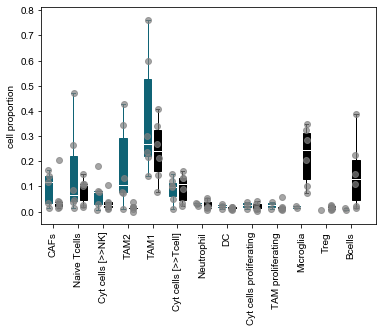

In [4]:
allcellprop = {}
for typ in ['CSF','TUMOR']:
    sampletypedf = SC_sel[SC_sel['Sample type']==typ]
    patient_totals = {pat:float(len(patdf)) for pat,patdf in sampletypedf.groupby('Patient ID')}
    allcellprop[typ] = {}
    for cell,celltypdf in sampletypedf.groupby('cluster_cell_class'):
        allcellprop[typ][cell] = [len(patdf)/patient_totals[pat] for pat,patdf in celltypdf.groupby('Patient ID')]
generate_paired_boxplot(SC.cluster_cell_class.unique(),allcellprop,'cell proportion','Ttest')

## FC tumor vs CSF

In [5]:
fc_sel_cols = [c for c in fc.columns if '(inside CD45)' in c]
fc['Sample type'] = fc['Sample type'].apply(lambda x:x.split('_')[0])
samples_sel = [sample for sample, sampledf in fc.groupby('Sample ID') if len(sampledf) > 1]
fc_paired = fc[fc['Sample ID'].isin(samples_sel)]

### Boxplot

/home/carlota/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Neutrophils (inside CD45) WilcoxonResult(statistic=3.0, pvalue=0.03569190011680441)
Bcells (inside CD45) WilcoxonResult(statistic=7.0, pvalue=0.12348527214454898)
DC (inside CD45) WilcoxonResult(statistic=8.0, pvalue=0.16142946236708333)
NK (inside CD45) WilcoxonResult(statistic=5.0, pvalue=0.0687035743228782)
TAMs (inside CD45) WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
Tcells (inside CD45) WilcoxonResult(statistic=16.0, pvalue=0.779434528427275)
CD4 (inside CD45) WilcoxonResult(statistic=16.0, pvalue=0.779434528427275)
CD8 (inside CD45) WilcoxonResult(statistic=17.0, pvalue=0.8886378608950078)
Treg (inside CD45) WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
T naïve (inside CD45) WilcoxonResult(statistic=7.0, pvalue=0.12348527214454898)


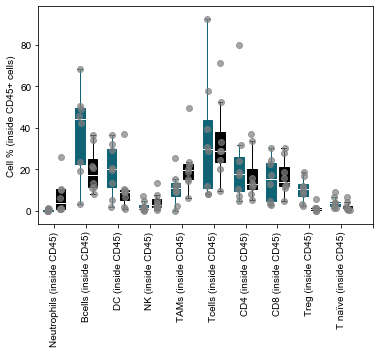

In [6]:
allcellprop = {}
for typ in ['CSF','TUMOR']:
    sampletypedf = fc_paired[fc_paired['Sample type']==typ]
    allcellprop[typ] = {}
    for cell in fc_sel_cols:
        allcellprop[typ][cell] = sampletypedf[cell].tolist()
generate_paired_boxplot(fc_sel_cols,allcellprop,'Cell % (inside CD45+ cells)','Wilcoxon')

/home/carlota/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


CD8/CD4 ratio WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)


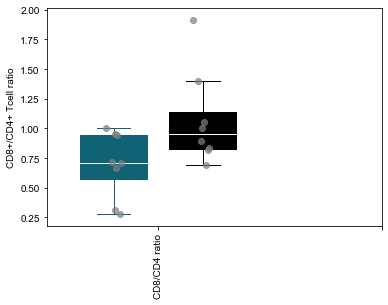

1.5437190974942965


In [16]:
allcellprop = {}
for typ in ['CSF','TUMOR']:
    sampletypedf = fc_paired[fc_paired['Sample type']==typ]
    allcellprop[typ] = {}
    allcellprop[typ]['CD8/CD4 ratio'] = sampletypedf['CD8/CD4 ratio'].tolist()
    
generate_paired_boxplot(['CD8/CD4 ratio'],allcellprop,'CD8+/CD4+ Tcell ratio','Wilcoxon')
print(np.mean(allcellprop['TUMOR']['CD8/CD4 ratio'])/np.mean(allcellprop['CSF']['CD8/CD4 ratio']))

### volcano plot

In [10]:
samples_sel = [sample for sample, sampledf in fc.groupby('Sample ID') if len(sampledf) > 1]
fc_paired = fc[fc['Sample ID'].isin(samples_sel)]

/home/carlota/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


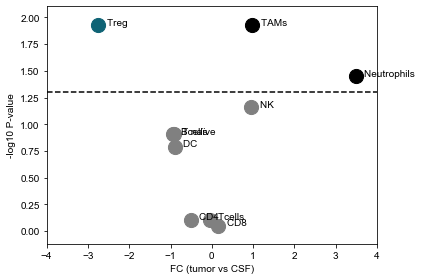

In [11]:
for impop in fc_sel_cols:
    fc = np.log2(np.mean(allcellprop['TUMOR'][impop])/np.mean(allcellprop['CSF'][impop]))
    u,pvalue = wilcoxon(allcellprop['TUMOR'][impop],allcellprop['CSF'][impop])
    logpvalue = -1*np.log10(pvalue)
    if pvalue < 0.05:
        if fc > 0 :
            color = 'black'
        else:
            color = '#0f6375'
        #plt.text(fc,logpvalue,impop)
    else:
        color = 'grey'
    plt.scatter(fc,logpvalue,color=color,s=200)
    plt.text(fc+0.2,logpvalue,impop.replace('(inside CD45)',''))
    
plt.xlabel('FC (tumor vs CSF)')
plt.ylabel('-log10 P-value')
plt.hlines(xmax=4,xmin=-4,y=1.3,linestyles='--')
plt.xlim(-4,4)
plt.tight_layout()
plt.show()